In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import plenoptic as po
import scipy.io as sio
import os
import os.path as op
import glob
import math
import pyrtools as pt
from tqdm import tqdm
from PIL import Image
%load_ext autoreload
%autoreload 

# download some texture files if you don't already have them:
import sys
sys.path.append('../tests/')
from test_metric import osf_download
results_dir = osf_download('portilla_simoncelli_images.tar.gz')
DATA_PATH = '../data/portilla_simoncelli_images/images/'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# These variables control how long metamer synthesis runs for. The values present here will result in completed synthesis,
# but you may want to decrease these numbers if you're on a machine with limited resources.
short_synth_max_iter = 1000
long_synth_max_iter = 3000
longest_synth_max_iter = 4000

# Portilla-Simoncelli Texture Metamer tutorial

**In this tutorial we will aim to replicate [Portilla & Simoncelli (1999)](https://www.cns.nyu.edu/pub/eero/portilla99-reprint.pdf). The tutorial is broken into the following parts:**
1. Introduce the concept of a Visual Texture.
2. How to compute metamers for the Portilla & Simoncelli texture model. 
3. Demonstrate the importance of different classes of statistics.
4. Example syntheses from different classes of textures (e.g., artificial, Julesz, pseudoperiodic, etc.)
5. Extrapolation and Mixtures: Applying texture synthesis to more complex texture problesm.
6. List of notable differences between the MATLAB and python implementations of the Portilla Simoncelli texture model and texture synthesis.

## 1 What is a visual texture?

The simplest definition is a repeating visual pattern. Textures encompass a wide variety of images, including natural patterns such as bark or fur, man-made ones such as brick, and computer-generated ones such as the Julesz patterns ([Julesz 1978](https://opg.optica.org/view_article.cfm?pdfKey=599829ad-ee45-47f0-a13e6083dd6ba76d_168451), [Yellot 1993](https://opg.optica.org/view_article.cfm?pdfKey=9d46b1d2-fd52-4800-ab75c12dc99781c5_4624)). Below we load some examples.  

The Portilla-Simoncelli model was developed to measure the statistical properties of visual textures.  Metamer synthesis was used (and can be used) in conjunction with the Portilla-Simoncelli texture model to demonstrate the necessity of different properties of the visual texture.  We will use some of these example textures to demonstrate aspects of the Portilla Simoncelli model.

Natural Images


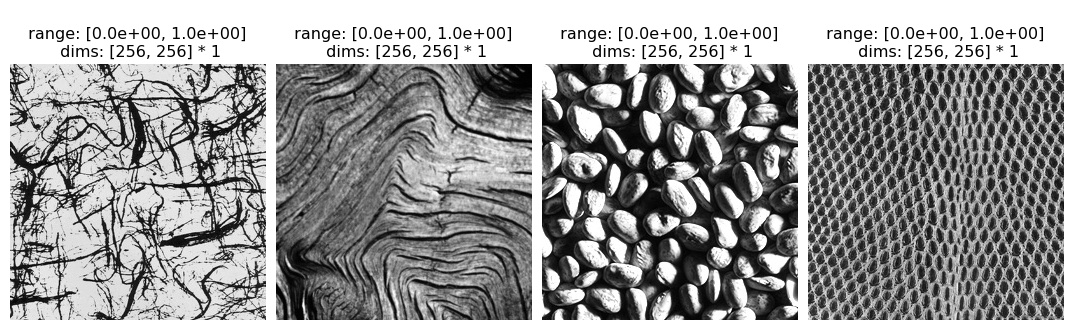

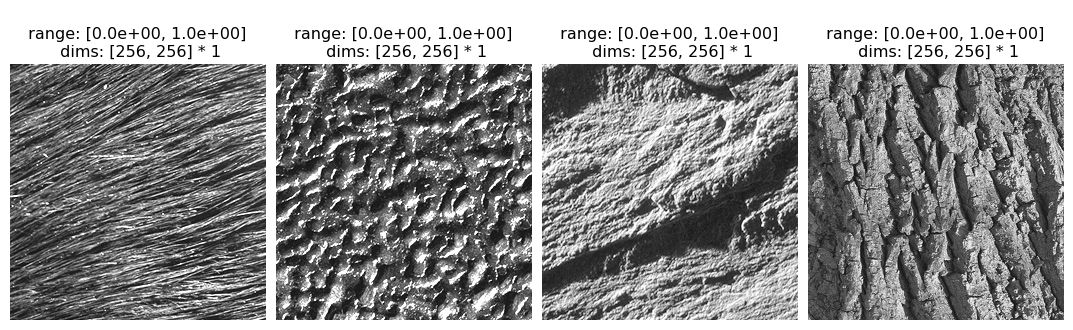

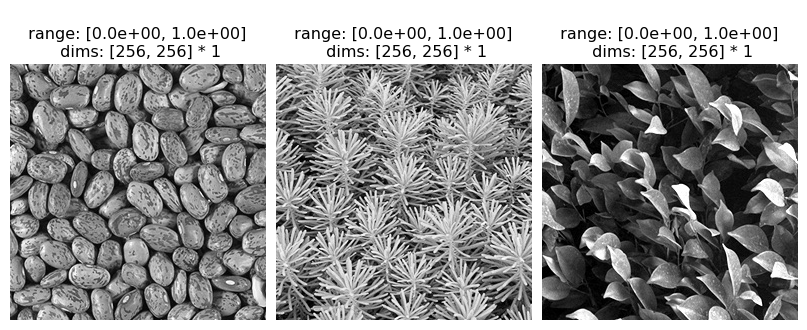

In [97]:
# Load and display a set of visual textures

def display_images(im_files):
    images = po.tools.load_images(im_files)
    nImages = len(images)
    nImagesPerRow = 4
    for ii in range(0,math.ceil(nImages/nImagesPerRow)*nImagesPerRow,nImagesPerRow):
        po.imshow(images[ii:ii+nImagesPerRow])

directory = DATA_PATH
natural = ['3a','6a','8a','14b','15c','15d','15e','15f','16c','16b','16a']
manmade = ['4a','4b','14a','16e','14e','14c','5a']
artificial = ['5b','13a','13b','13c','13d']

im_files = [os.path.join(directory, 'fig'+num+'.jpg') for num in natural]
print('Natural Images')
display_images(im_files)


Man-made Images


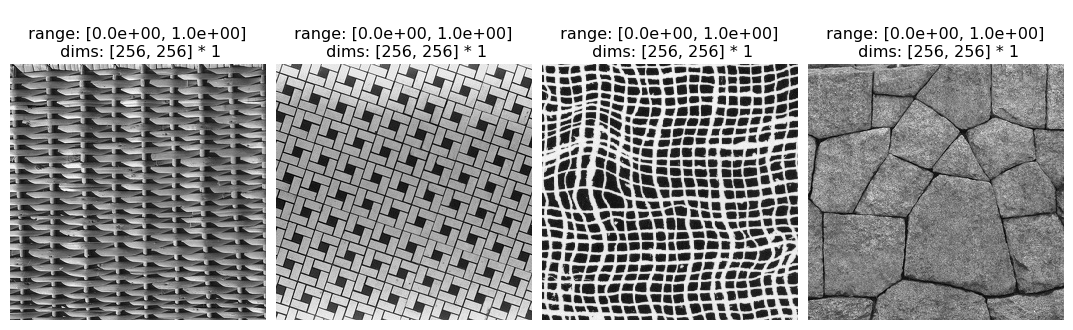

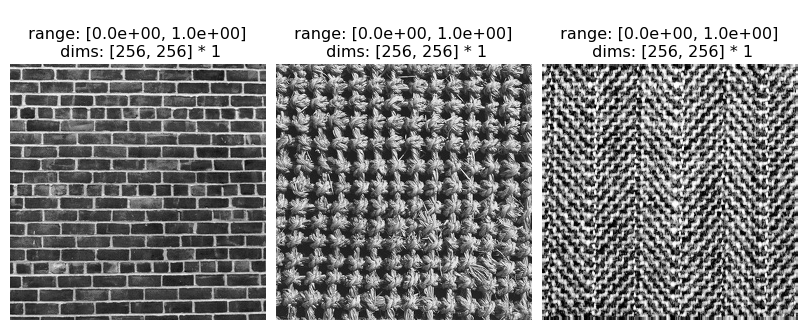

In [98]:
im_files = [os.path.join(directory, 'fig'+num+'.jpg') for num in manmade]
print('Man-made Images')
display_images(im_files)

Artificial Images


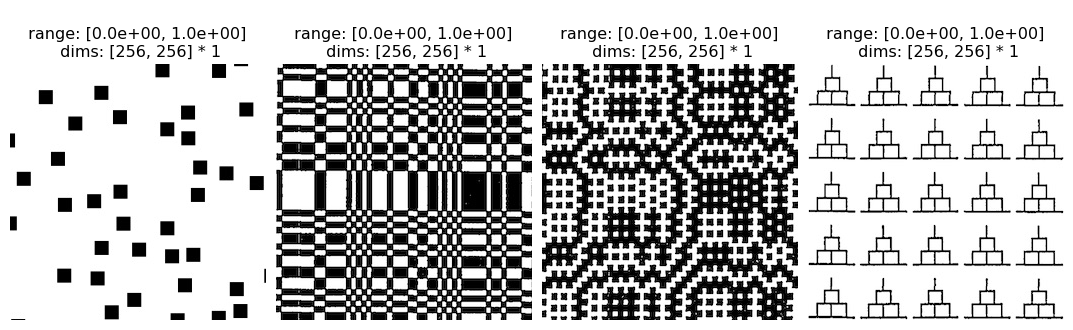

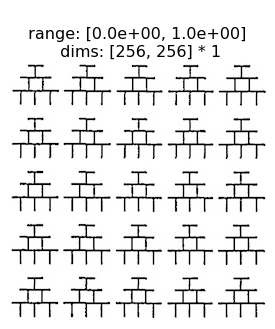

In [47]:
im_files = [os.path.join(directory, 'fig'+num+'.jpg') for num in artificial]
print('Artificial Images')
display_images(im_files)


## 2. How to generate Portilla-Simoncelli Metamers

### 2.1 A quick reminder of what metamers are and why we are calculating them.

The primary reason that the original Portilla-Simoncelli paper developed the metamer procedure was to assess whether a model sees like human.  Basically we generate samples of images that "look the same" to the model and see if they also "look the same" to a human.

### 2.2 How do we use the plenoptic package to generate Portilla-Simoncelli Texture Metamers?
For a model, two images are metamers if the model response to both images is equal (within some tolerance).  Generating a metamer starts with a target image:

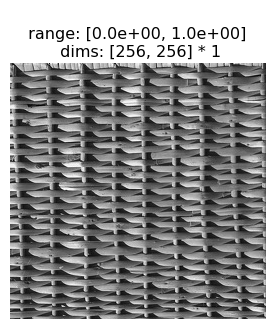

In [13]:
img = po.tools.load_images(['../data/portilla_simoncelli_images/images/fig4a.jpg'])
po.imshow(img);

Below we have an instance of the PortillaSimoncelli model with default parameters.  
The default parameters of PortillaSimoncelli are:
- `n_scales=4`, The number of scales in the steerable pyramid underlying the model.
- `n_orientations=4`, The number of orientations in the steerable pyramid.
- `spatial_corr_width=9`, The size of the window used to calculate the correlations across steerable pyramid bands.

In [50]:
n=img.shape[-1]
# 1x1xnxn
model = po.simul.PortillaSimoncelli([n,n])
stats = model(img)
print(stats)

tensor([[[0.4350, 0.0407, 0.1622,  ..., 0.0000, 0.0000, 0.0023]]])


To use `Metamer`, simply initialize it with the target image and the model, then call `.synthesize()`. By setting `store_progress=True`, we update a variety of attributes (all of which start with `saved_`) on each iteration so we can later examine, for example, the synthesized image over time.  Let's quickly run it for just 10 iterations to see how it works.

In [51]:
met = po.synth.Metamer(img, model)
met.synthesize(store_progress=True, max_iter=10)

  0%|          | 0/10 [00:00<?, ?it/s]

tensor([[[[0.5569, 0.0684, 0.6536,  ..., 0.1908, 0.3453, 0.9986],
          [0.9423, 0.6238, 0.6278,  ..., 0.2134, 0.7104, 0.1304],
          [0.7585, 0.9868, 0.6578,  ..., 0.2093, 0.0797, 0.1860],
          ...,
          [0.5393, 0.8305, 0.6404,  ..., 0.9891, 0.9765, 0.5673],
          [0.2615, 0.9976, 0.7219,  ..., 1.0022, 0.5527, 0.7522],
          [0.5980, 0.3161, 0.3442,  ..., 0.5547, 0.2263, 0.5943]]]],
       requires_grad=True)

We then call the `plot_synthesis_status` method to see how things are doing. The image on the left shows the metamer at this moment, while the center plot shows the loss over time, with the red dot pointing out the current loss, and the rightmost plot shows the representation error. If a model has a `plot_representation` method, this plot can be more informative, but this plot can always be created. We here see the difference in representations split up across the different output channels.

/Users/kathrynbonnen/Documents/work-repos/plenoptic/plenoptic/tools/display.py:960: UserWarning: ax is not None, so we're ignoring figsize...
  warnings.warn("ax is not None, so we're ignoring figsize...")


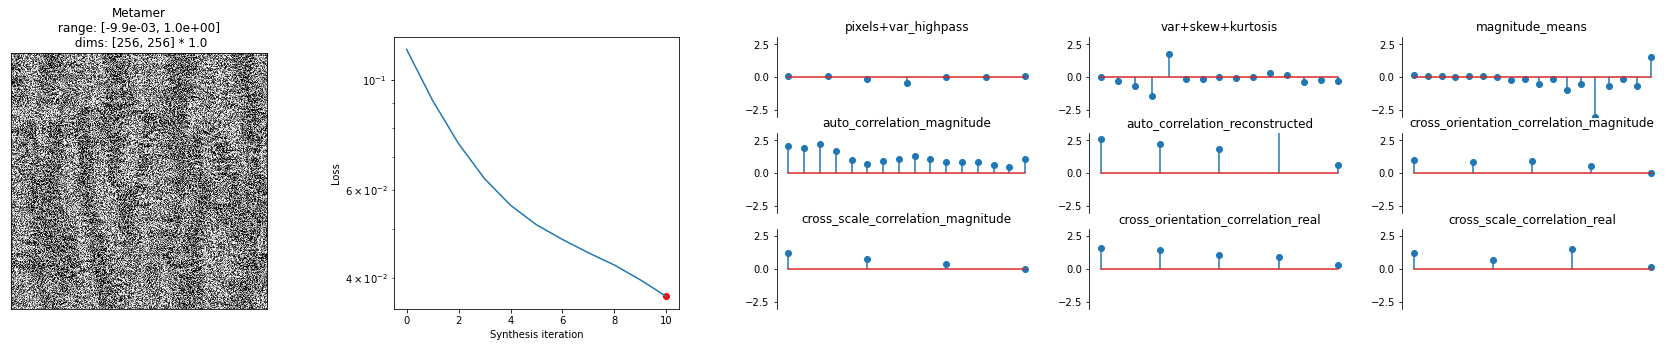

In [52]:
# representation_error plot has three subplots, so we increase its relative width
po.synth.metamer.plot_synthesis_status(met, width_ratios={'model_response_error': 3.1});

### 2.3 Portilla-Simoncelli Texture Model Metamers

This section will show a successful texture synthesis for this wicker basket texture:

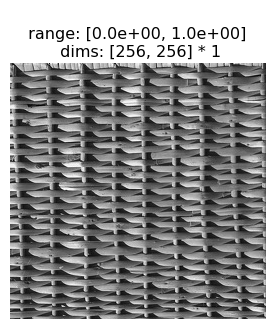

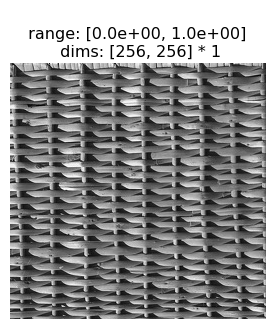

In [55]:
po.imshow(img)

In the next block we will actually generate a metamer using the PortillaSimoncelli model, setting the following parameters for synthesis: `max_iter`, `store_progress`,`coarse_to_fine`, and `coarse_to_fine_kwargs`.  
- `max_iter=1000` puts an upper bound (of 1000) on the number of iterations that the optimization will run.
- `store_progress=True` tells the metamer class to store the progress of the metamer synthesis process
- `coarse_to_fine='together'` activates the coarse_to_fine functionality.  With this mode turned on the metamer synthesis optimizes the image for the statistics associated with the low spatial frequency bands first, adding subsequent bands after `ctf_iters_to_check` iterations. (Note that you could also set a threshold for this using `change_scale_criterion`, but we set that to None to deactivate it.)

It takes about 50s to run 100 iterations on my laptop.  And it takes hundreds of iterations to get convergence. So you'll have to wait a few minutes to generate the texture metamer. 

Note: the first line in the next cell creates an initial uniform noise image with range mean(target_signal)+[-.05,.05].  Initial images with uniform random noise covering the full pixel domain [0,1] (which is the default choice for Metamer) don't result in the very best metamers.  With the full range initial image, the optimization seems to get stuck.

In [54]:

n=img.shape[-1]
# 1x1xnxn
model = po.simul.PortillaSimoncelli([n,n])
im_init = (torch.rand_like(img)-.5) * .1 + img.mean();
met = po.synth.Metamer(img, model, loss_function=po.tools.optim.l2_norm, initial_image=im_init)
o=met.synthesize(
    max_iter=short_synth_max_iter,
    store_progress=True,
    coarse_to_fine='together', 
    coarse_to_fine_kwargs={'change_scale_criterion': None, 'ctf_iters_to_check': 7}
    )



  0%|          | 0/1000 [00:00<?, ?it/s]

Now we can visualize the output of the synthesis optimization. First we compare the *Target image* and the *Synthesized image* side-by-side.

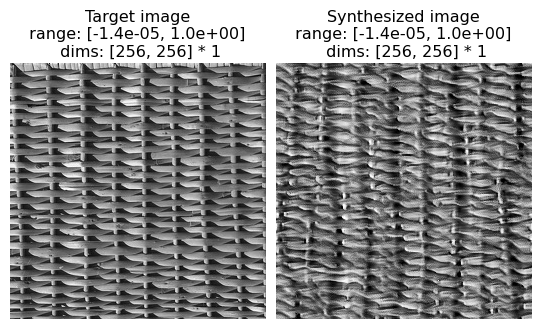

In [19]:
po.imshow([met.target_signal, met.synthesized_signal], title=['Target image', 'Synthesized image'], vrange='auto1');

And to further visualize the result we can plot: 1) the synthesized image, 2) the decreasing loss, and 3-end) the final model output error: `model(target image) - model(synthesized image)`.

We can see the synthesized texture on the left.  The overall synthesis error decreases over the synthesis iterations (subplot 2).  The remaining plots show us the error broken out by the different texture statistics that we will go over in the next section.

/Users/kathrynbonnen/Documents/work-repos/plenoptic/plenoptic/tools/display.py:960: UserWarning: ax is not None, so we're ignoring figsize...
  warnings.warn("ax is not None, so we're ignoring figsize...")


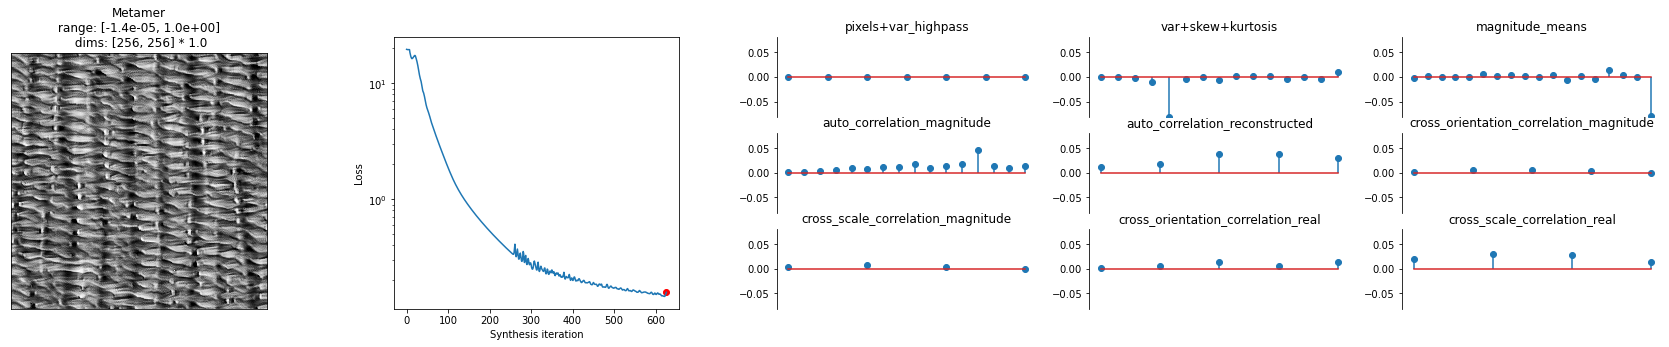

In [20]:
po.synth.metamer.plot_synthesis_status(met, width_ratios={'model_response_error': 3.1});

## 3 The importance of different classes Texture Statistics
The Portilla-Simoncelli consists of a few different classes of statistics:
- Marginal Statistics.  These include pixel statistics (mean, variance, skew, kurtosis, and range of the pixel values), as well as the skewness and kurtosis of the lowpass images computed at each level of the recursive pyramid decomposition.
- Auto-Correlation Statistics.  These include the auto-correlation of the real-valued pyramid bands, as well as the auto-correlation of the magnitude of the pyramid bands, and the mean of the magnitude of the pyramid bands.
- Cross-Correlation Statistics.  These include correlations across scale and across orientation bands of the pyramid (both the for the real values of the pyramid and the magnitude of the pyramid bands).

The original paper uses synthesis to demonstrate the role of these different types of statistics.  They show that the statistics can be used to constrain a synthesis optimization to generate new examples of textures.  They also show that the absence of subsets of statistics results in synthesis failures.  Here we replicate those results.

The first step is to create a version of the Portilla Simoncelli model where certain statistics can be turned off.

In [7]:
from IPython.display import HTML
from IPython.display import display

# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)


from collections import OrderedDict
class PortillaSimoncelliRemove(po.simul.PortillaSimoncelli):
    r"""Model for measuring a subset of texture statistics reported by PortillaSimoncelli

    Currently we do not support batch measurement of images.

    Parameters
    ----------
    im_shape: int
        the size of the images being processed by the model
    remove_keys: list
        The dictionary keys for the statistics we will "remove".  In practice we set them to zero.
        Possible keys: ["pixel_statistics", "magnitude_means", "auto_correlation_magnitude",
        "skew_reconstructed", "kurtosis_reconstructed", "auto_correlation_reconstructed", 
        "std_reconstructed", "cross_orientation_correlation_magnitude", "cross_scale_correlation_magnitude"
        "cross_orientation_correlation_real", "var_highpass_residual"]
        
    n_scales: int, optional
        The number of pyramid scales used to measure the statistics (default=4)
    n_orientations: int, optional
        The number of orientations used to measure the statistics (default=4)
    spatial_corr_width: int, optional
        The width of the spatial cross- and auto-correlation statistics in the representation
    use_true_correlations: bool
        In the original Portilla-Simoncelli model the statistics in the representation
        that are labelled correlations were actually covariance matrices (i.e. not properly
        scaled).  In order to match the original statistics use_true_correlations must be
        set to false. But in order to synthesize metamers from this model use_true_correlations
        must be set to true (default).

    """
    def __init__(
        self,
        im_shape,
        remove_keys,
        n_scales=4,
        n_orientations=4,
        spatial_corr_width=9,
        use_true_correlations=True
    ):
        super().__init__(im_shape, n_scales=4, n_orientations=4, spatial_corr_width=9, use_true_correlations=True)
        
        self.remove_keys = remove_keys
        
    def forward(self, image, scales=None):
        
        r"""Generate Texture Statistics representation of an image with `remove_keys` removed.

        Parameters
        ----------
        image : torch.Tensor
            A tensor containing the image to analyze. We want to operate
            on this in the pytorch-y way, so we want it to be 4d (batch,
            channel, height, width). If it has fewer than 4 dimensions,
            we will unsqueeze it until its 4d
        scales : list, optional
            Which scales to include in the returned representation. If an empty
            list (the default), we include all scales. Otherwise, can contain
            subset of values present in this model's ``scales`` attribute.

        Returns
        -------
        representation_vector: torch.Tensor
            A flattened tensor (1d) containing the measured representation statistics.

        """
        
        stats=super().forward(image,scales=scales)
        stats_dict = self.convert_to_dict(stats)
        
        for kk in self.remove_keys:
            if isinstance(stats_dict[kk],OrderedDict):
                for (key,val) in stats_dict[kk].items():
                    stats_dict[kk][key] *= 0
            else:
                stats_dict[kk]*=0  # why can't you just remove the values here? there was a logistical problem, but what was it?

        list_of_stats = [
            torch.cat([vv.flatten() for vv in val.values()])
            if isinstance(val, OrderedDict)
            else val.flatten()
            for (key, val) in stats_dict.items()
        ]
        return torch.cat(list_of_stats)


def comparison(img_file, remove_statistics,seed=1):
    r""" Performs synthesis twice:  1) With the full Portilla-Simoncelli model. 
    2) Without the statistics specified by `remove_statistics`

        Parameters
        ----------
        img_file : 
            A tensor containing the file location for the image to be analyzed.
        remove_statistics : list
            Which statistics to remove in the returned representation. 

        Returns
        -------
        met: Metamer
            Metamer from the full Portilla-Simoncelli Model
    
        met_select: Metamer
            Metamer from the Portilla-Simoncelli Model with some statistics removed.

        """
    img = po.tools.load_images(img_file)
    im_init = torch.rand_like(img) * .01 + img.mean()
    n=img.shape[-1]
    model = po.simul.PortillaSimoncelli([n,n])
    
    po.tools.set_seed(seed)
    model_select = PortillaSimoncelliRemove([n,n],remove_statistics)
    met = po.synth.Metamer(img, model, loss_function=po.tools.optim.l2_norm, initial_image=im_init)
    met.synthesize(
        max_iter=short_synth_max_iter, 
        store_progress=True,
        coarse_to_fine='together',
        coarse_to_fine_kwargs={'change_scale_criterion': None, 'ctf_iters_to_check': 7}
        )
    
    po.tools.set_seed(seed)
    met_select = po.synth.Metamer(img, model_select, loss_function=po.tools.optim.l2_norm, initial_image=im_init)
    met_select.synthesize(
        max_iter=short_synth_max_iter, 
        store_progress=True,
        coarse_to_fine='together',
        coarse_to_fine_kwargs={'change_scale_criterion': None, 'ctf_iters_to_check': 7}
        )
    
    return met, met_select


### Pixel Statistics + Marginal statistics 
Beginning with some of the pixel and marginal statistics, we'll demonstrate synthesis both with and without combinations of statistics.

The cell below replicates examples of synthesis failures with the following statistics removed:
- the pixel statistics: mean, variance, skew, kurtosis, minimum, maximum and 
- marginal statistics on the lowpass images computed at each level of the recursive pyramid (skew, kurtosis)

These statistics play an important role constraining the histogram of pixel intensities to match across the original and synthesized image. 

(see figure 3 of Portilla & Simoncelli 2000)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

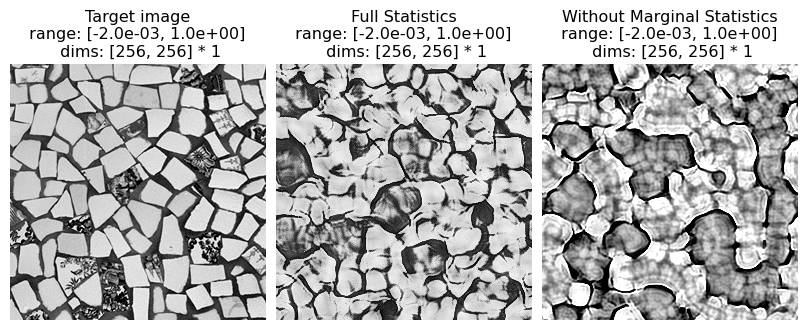

In [59]:
# make sure that the seed is getting set to the same.

# which statistics to remove
remove_statistics=['pixel_statistics','skew_reconstructed','kurtosis_reconstructed','magnitude_means']

# synthesis -- run on fig3a and fig3b to replicate paper
metamer, metamer_select = comparison(DATA_PATH + 'fig3b.jpg', remove_statistics,seed=1) 

# visualize results
po.imshow([metamer.target_signal, metamer.synthesized_signal, metamer_select.synthesized_signal], title=['Target image', 'Full Statistics','Without Marginal Statistics'], vrange='auto1');

### Coefficient Correlations 
The cell below replicates examples of synthesis failures with the following statistics removed:
- local auto-correlations of the lowpass images computed at each level of the recursive pyramid

These statistics play a role in representing periodic structures and long-range correlations. For example, in the image named fig4a.jpg (the woven pattern) the absence of these statistics causes curves and even curved crossings in the texture absent in the synthesis with the full statistics.

(see figure 4 of Portilla & Simoncelli 2000)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

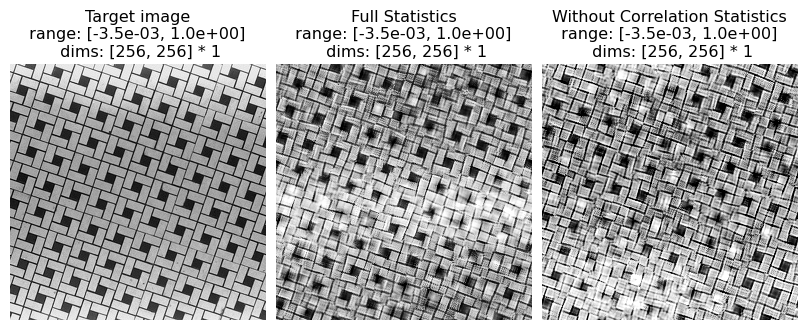

In [60]:
# which statistics to remove
remove_statistics = ['auto_correlation_reconstructed']

# synthesis -- run on fig4a and fig4b to replicate paper
metamer, metamer_select = comparison(DATA_PATH + 'fig4b.jpg', remove_statistics) 

# visualize results
po.imshow([metamer.target_signal, metamer.synthesized_signal, metamer_select.synthesized_signal], title=['Target image', 'Full Statistics','Without Correlation Statistics'], vrange='auto1');

### Magnitude Correlation 
The cell below replicates examples of synthesis failures with the following statistics removed:
- correlation of the complex magnitude of pairs of coefficients at adjacent positions, orientations and scales.

These statistics play a role constraining high contrast locations to be organized along lines and edges across all scales. For example, in the image named fig6a.jpg the absence of these statistics results in a completely different organization of the orientation content in the edges.

(see figure 6 of Portilla & Simoncelli 2000)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

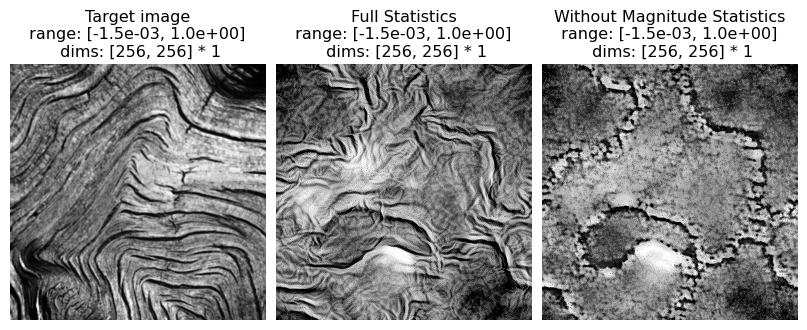

In [40]:
# which statistics to remove
remove_statistics = ['cross_orientation_correlation_magnitude','cross_scale_correlation_magnitude','auto_correlation_magnitude']

# synthesis -- run on fig6a and fig6b to replicate paper
metamer, metamer_select = comparison(DATA_PATH + 'fig6a.jpg', remove_statistics) 

# visualize results
po.imshow([metamer.target_signal, metamer.synthesized_signal, metamer_select.synthesized_signal], title=['Target image', 'Full Statistics','Without Magnitude Statistics'], vrange='auto1');

### Cross-scale Phase Statistics 
The cell below replicates examples of synthesis failures with the following statistics removed :
- relative phase of coefficients of bands at adjacent scales

These statistics play a role constraining high contrast locations to be organized along lines and edges across all scales. These phase statistics are important in representing textures with strong illumination effects. When they are removed, the synthesized images appear much less three dimensional and lose the detailed structure of shadows.

(see figure 8 of Portilla & Simoncelli 2000)

In [1]:
# which statistics to remove
remove_statistics = ['cross_scale_correlation_real']

# run on fig8a and fig8b to replicate paper
metamer, metamer_select = comparison(DATA_PATH + 'fig8b.jpg', remove_statistics) 

# visualize results
po.imshow([metamer.target_signal, metamer.synthesized_signal, metamer_select.synthesized_signal], title=['Target image', 'Full Statistics','Without Cross-Scale Phase Statistics'], vrange='auto1');

NameError: name 'comparison' is not defined

## 3. Examples from different texture classes

### Artificial Textures 


(see figure 12 of Portilla Simoncelli 2000)

The following cell can be used to reproduce texture synthesis on the artificial texture examples in the original paper.

Examples
- (12a) solid black squares
- (12b) tilted gray columns
- (12c) curvy lines
- (12d) dashes
- (12e) solid black circles
- (12f) pluses

In [ ]:
def run_synthesis(img_file,im_init=None,use_true_correlations=True):
    r""" Performs synthesis with the full Portilla-Simoncelli model. 

        Parameters
        ----------
        img_file : 
            A tensor containing the file location for the image to be analyzed.

        Returns
        -------
        met: Metamer
            Metamer from the full Portilla-Simoncelli Model
    
        met_select: Metamer
            Metamer from the Portilla-Simoncelli Model with some statistics removed.

        """
    img = po.tools.load_images(img_file)
    if im_init==None:
        im_init = torch.rand_like(img) * .01 + img.mean()
    n=img.shape[-1]


    model = po.simul.PortillaSimoncelli([n,n],use_true_correlations=use_true_correlations)
    met = po.synth.Metamer(img, model, loss_function=po.tools.optim.l2_norm, initial_image=im_init)
    met.synthesize(
        max_iter=long_synth_max_iter, 
        store_progress=True,
        coarse_to_fine='together',
        coarse_to_fine_kwargs={'change_scale_criterion': None, 'ctf_iters_to_check': 3}
        )
    return met

  0%|          | 0/3000 [00:00<?, ?it/s]

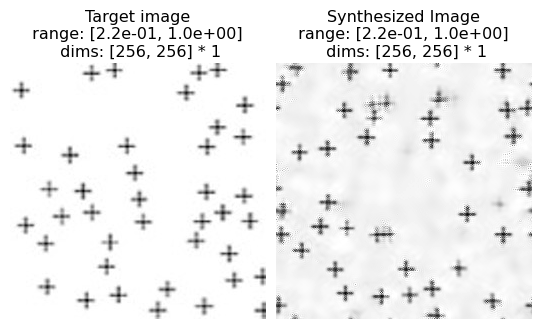

In [87]:
metamer = run_synthesis([DATA_PATH + 'fig12f.jpg'])
po.imshow([metamer.target_signal, metamer.synthesized_signal], title=['Target image', 'Synthesized Image'], vrange='auto1');

### Counterexample to the Julesz Conjecture

Julesz conjecture stated that.... But these examples meet those criteria and we can distinguish them.  So can our models.

(see figure 13 of Portilla & Simoncelli 2000)

Excerpt from paper: _"Figure 13 shows two pairs of counterexamples that have been used to refute the Julesz conjecture. \[13a and 13b were \] originally created by Julesz et al. (1978): they have identical third-order pixel statistics, but are easily discriminated by human observers. Our model succeeds, in that it can reproduce the visual appearance of either of these textures. In particular, we have seen that the strongest statistical difference arises in the magnitude correlation statistcs. The rightmost pair were constructed by Yellott (1993), to have identical sample autocorrelation. Again, our model does not confuse these, and can reproduce the visual appearance of either one."_

  0%|          | 0/3000 [00:00<?, ?it/s]

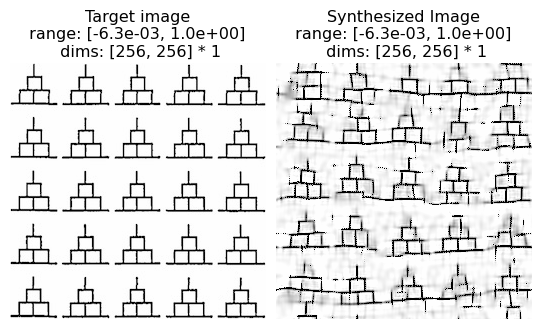

In [88]:
# Run on fig13a, fig13b, fig13c, fig13d to replicate examples in paper
metamer = run_synthesis(DATA_PATH + 'fig13c.jpg') 
po.imshow([metamer.target_signal, metamer.synthesized_signal], title=['Target image', 'Synthesized Image'], vrange='auto1');

# 

### Pseudo-periodic Textures 

(see figure 14 of Portilla & Simoncelli 2000)

Excerpt from paper: _"Figure 14 shows synthesis results photographic textures that are pseudo-periodic, such as a brick wall and various types of woven fabric"_

  0%|          | 0/1000 [00:00<?, ?it/s]

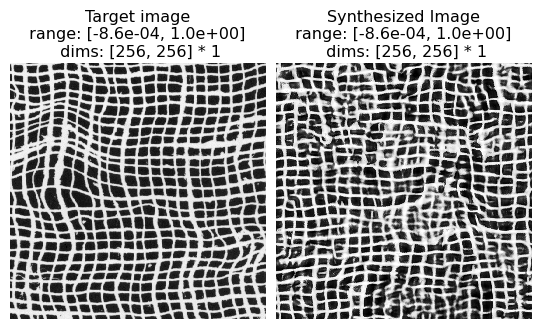

In [44]:
# Run on fig14a, fig14b, fig14c, fig14d, fig14e, fig14f to replicate examples in paper
metamer = run_synthesis(DATA_PATH + 'fig14a.jpg') 
po.imshow([metamer.target_signal, metamer.synthesized_signal], title=['Target image', 'Synthesized Image'], vrange='auto1');

### Aperiodic Textures 

(see figure 15 of Portilla & Simoncelli 2000)

Excerpt from paper: _"Figure 15 shows synthesis results for a set of photographic textures that are aperiodic, such as the animal fur or wood grain"_

  0%|          | 0/1000 [00:00<?, ?it/s]

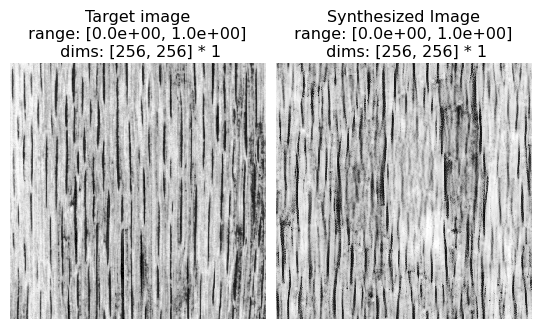

In [65]:
# Run on fig15a, fig15b, fig15c, fig15d to replicate examples in paper
metamer = run_synthesis(DATA_PATH + 'fig15a.jpg') 
po.imshow([metamer.target_signal, metamer.synthesized_signal], title=['Target image', 'Synthesized Image'], vrange='auto1');

### Complex Structured Photographic Textures 

(see figure 16 of Portilla & Simoncelli 2000)

Excerpt from paper: _"Figure 16 shows several examples of textures with complex structures. Although the synthesis quality is not as good as in previous examples, we find the ability of our model to capture salient visual features of these textures quite remarkable. Especially notable are those examples in all three figures for which shading produces a strong impression of three-dimensionality."_

  0%|          | 0/1000 [00:00<?, ?it/s]

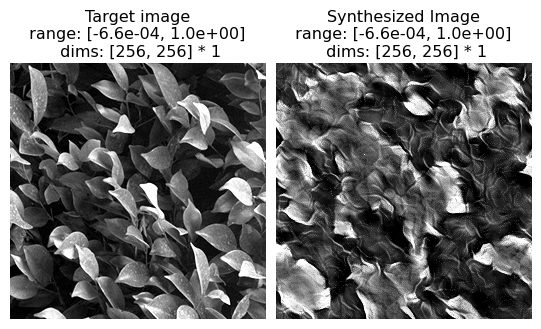

In [46]:
# Run on fig16a, fig16b, fig16c, fig16d to replicate examples in paper
metamer = run_synthesis(DATA_PATH + 'fig16a.jpg') 
po.imshow([metamer.target_signal, metamer.synthesized_signal], title=['Target image', 'Synthesized Image'], vrange='auto1');

## 4.1 Extrapolation

Here we explore using the texture synthesis model for filling in.  Using the texture statistics from an image we replace a section of the image using synthesis.

Excerpt from paper: _"...\[C\]onsider the problem of extending a texture image beyond its spatial boundaries (spatial extrapolation). We want to synthesize an image in which the central pixels contain a copy of the original image, and the surrounding pixels are synthesized based on the statistical measurements of the original image. The set of all images with the same central subset of pixels is convex, and the projection onto such a convex set is easily inserted into the iterative loop of the synthesis algorithm. Specifically, we need only re-set the central pixels to the desired values on each iteration of the synthesis loop. In practice, this substitution is done by multiplying the desired pixels by a smooth mask (a raised cosine) and adding this to the current synthesized image multiplied by the complement of this mask. The smooth mask prevents artifacts at the boundary between original and synthesized pixels, whereas convergence to the desired pixels within the mask support region is achieved almost perfectly. This technique is applicable to the restoration of pictures which have been destroyed in some subregion (“filling holes”) (e.g., Hirani and Totsuka, 1996), although the estimation of parameters from the defective image is not straightforward. Figure 19 shows a set of examples that have been spatially extrapolated using this method. Observe that the border between real and synthetic data is barely noticeable. An additional potential benefit is that the synthetic images are seamlessly periodic (due to circular boundary-handling within our algorithm), and thus may be used to tile a larger
image."_

In [4]:
class MetamerFill(po.synth.Metamer):
    r"""Model for using the texture statistics reported by PortillaSimoncelli to fill in an image.


    Parameters
    ----------


    """

    def __init__(self, target_signal: torch.Tensor, model: torch.nn.Module, mask: torch.Tensor,
             range_penalty_lambda = .1,
             loss_function = po.tools.optim.mse,
             allowed_range = (0, 1),
             initial_image = None):
        
        super().__init__(target_signal,
                        model,
                        loss_function = loss_function,
                        range_penalty_lambda=range_penalty_lambda,
                        allowed_range=allowed_range,
                        initial_image=initial_image)
        self.optimizer_mask = mask;

    
    def _init_optimizer(self, optimizer, scheduler):
        """Initialize optimizer and scheduler."""
        if optimizer is None:
            if self.optimizer is None:
                self.optimizer = torch.optim.Adam([torch.masked_select(self.synthesized_signal, self.optimizer_mask)],
                                                  lr=.01, amsgrad=True)
        else:
            if self.optimizer is not None:
                raise Exception("When resuming synthesis, optimizer arg must be None!")
            params = optimizer.param_groups[0]['params']
            if len(params) != 1 or not torch.equal(params[0], self.synthesized_signal):
                raise Exception("For metamer synthesis, optimizer must have one "
                                "parameter, the metamer we're synthesizing.")
            self.optimizer = optimizer
        self.scheduler = scheduler
        for pg in self.optimizer.param_groups:
            # initialize initial_lr if it's not here. Scheduler should add it
            # if it's not None.
            if 'initial_lr' not in pg:
                pg['initial_lr'] = pg['lr']
                
def run_fill_synthesis(img_file, mask):
    img = po.tools.load_images(img_file)
    im_init = torch.rand_like(img) * .01 + img.mean()
    im_init[~mask] = img[~mask]
    
    n=img.shape[-1]
    
    model = po.simul.PortillaSimoncelli([n,n])
    met = MetamerFill(img, model, mask, loss_function=po.tools.optim.l2_norm, initial_image=im_init)
    optimizer = torch.optim.Adam([met.synthesized_signal],lr=.005, amsgrad=True)
    met.synthesize(
        optimizer=optimizer,
        max_iter=longest_synth_max_iter, 
        store_progress=True,
        coarse_to_fine='together',
        coarse_to_fine_kwargs={'change_scale_criterion': None, 'ctf_iters_to_check': 3}
        )
    return met


/Users/kathrynbonnen/Documents/work-repos/plenoptic/plenoptic/simulate/models/portilla_simoncelli.py:552: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1616554799287/work/aten/src/ATen/native/Copy.cpp:219.)
  return im_large.type(im.dtype)


  0%|          | 0/4000 [00:00<?, ?it/s]

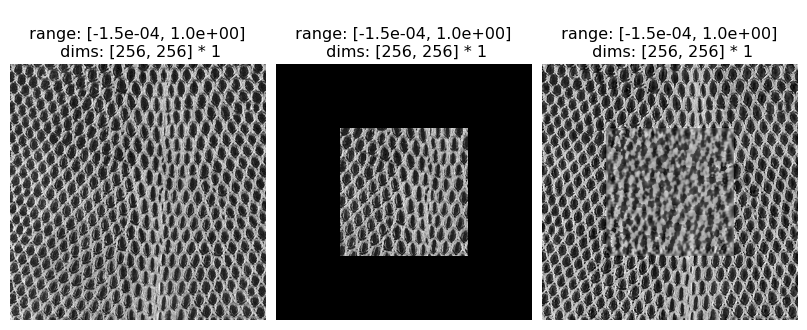

In [5]:
img_file = DATA_PATH + 'fig14b.jpg'
img = po.tools.load_images(img_file)
mask=torch.zeros(1,1,256,256).bool()
mask[:,:,64:192,64:192]=True
masked_image = img;
masked_image = img*mask

met = run_fill_synthesis(img_file,mask)
po.imshow([met.target_signal,masked_image,met.synthesized_signal], vrange='auto1');

## 4.2 Mixtures

Here we explore creating a texture that is "in between" two textures by averaging their texture statistics and synthesizing an image that matches those average statistics.  \[Note: This implementation seems to perform differently and perhaps worse than the original matlab implementation.\]

Excerpt from paper: _"... \[C\]onsider the problem of creating a texture that lies visually “in between” two other textures. The parameter space consisting of spatial averages of local functions has a type of convexity property in the limit as the image lattice grows in size.3 Figure 20 shows three images synthesized from parameters that are an average of the parameters for two example textures. In all three cases, the algorithm converges to an interesting-looking image that appears to be a patchwise mixtures of the two initial textures, rather than a new homogeneous texture that lies perceptually between them. Thus, in our model, the subset of parameters corresponding to textures (homogeneous RFs) is not convex!"_

In [29]:
class PortillaSimoncelliMixture(po.simul.PortillaSimoncelli):

    def __init__(
        self,
        im_shape,
        n_scales=4,
        n_orientations=4,
        spatial_corr_width=9,
        use_true_correlations=True
    ):
        super().__init__(im_shape, n_scales=4, n_orientations=4, spatial_corr_width=9, use_true_correlations=True)
        
        
    def forward(self, imgs, scales=None):
        
        if imgs.shape[0]==2:
            stats0=super().forward(imgs[0,:,:,:],scales=scales)
            stats1=super().forward(imgs[1,:,:,:],scales=scales)

            return (stats0+stats1)/2
        
        elif imgs.shape[0]==1:
            stats = super().forward(imgs,scales=scales)
            return stats
            
class MetamerMixture(po.synth.Metamer):
    
    def _init_synthesized_signal(self, initial_image = None):
        """Initialize the synthesized image.

        Set the ``self.synthesized_signal`` attribute to be a parameter with
        the user-supplied data, making sure it's the right shape.

        Parameters
        ----------
        initial_image :
            The tensor we use to initialize the metamer. If None (the
            default), we initialize with uniformly-distributed random
            noise lying between 0 and 1.

        """
        if initial_image is None:
            synthesized_signal = torch.rand_like(self.target_signal)
            # rescale synthesized_signal to lie within the interval
            # self.allowed_range
            synthesized_signal = signal.rescale(synthesized_signal, *self.allowed_range)
            synthesized_signal.requires_grad_()
        else:
            synthesized_signal = initial_image.clone().detach()
            synthesized_signal = synthesized_signal.to(dtype=self.target_signal.dtype,
                                                       device=self.target_signal.device)
            synthesized_signal.requires_grad_()
            if synthesized_signal.ndimension() < 4:
                raise Exception("synthesized_signal must be torch.Size([n_batch"
                                ", n_channels, im_height, im_width]) but got "
                                f"{synthesized_signal.size()}")
        self.synthesized_signal = synthesized_signal
        self.losses.append(self.objective_function(self.model(synthesized_signal)).item())

def run_mixture_synthesis(img_files):
    imgs = po.tools.load_images(img_files)
    im_init = torch.rand_like(imgs[0,:,:,:].unsqueeze(0)) * .01 + imgs.mean()
    n=imgs.shape[-1]

    model = PortillaSimoncelliMixture([n,n])
    met = MetamerMixture(imgs, model, loss_function=po.tools.optim.l2_norm, initial_image=im_init)
    
    optimizer = torch.optim.Adam([met.synthesized_signal],lr=.02, amsgrad=True)

    met.synthesize(
        optimizer=optimizer,
        max_iter=longest_synth_max_iter, 
        store_progress=True,
        coarse_to_fine='together',
        coarse_to_fine_kwargs={'change_scale_criterion': None, 'ctf_iters_to_check': 3}
        )
    return met

In [83]:
# Figure 20. Examples of “mixture” textures.
# To replicate paper use the following combinations: 
# (Fig. 15a, Fig. 15b); (Fig. 14b, Fig. 4a); (Fig. 15e, Fig. 14e).

imgs = [DATA_PATH + 'fig14b.jpg', DATA_PATH + 'fig4a.jpg']
met = run_mixture_synthesis(imgs)
po.imshow([met.target_signal,met.synthesized_signal], vrange='auto1',title=['Target image 1', 'Target image 2', 'Synthesized Mixture Image']);

NameError: name 'run_mixture_synthesis' is not defined

/Users/kathrynbonnen/Documents/work-repos/plenoptic/plenoptic/tools/display.py:960: UserWarning: ax is not None, so we're ignoring figsize...
  warnings.warn("ax is not None, so we're ignoring figsize...")


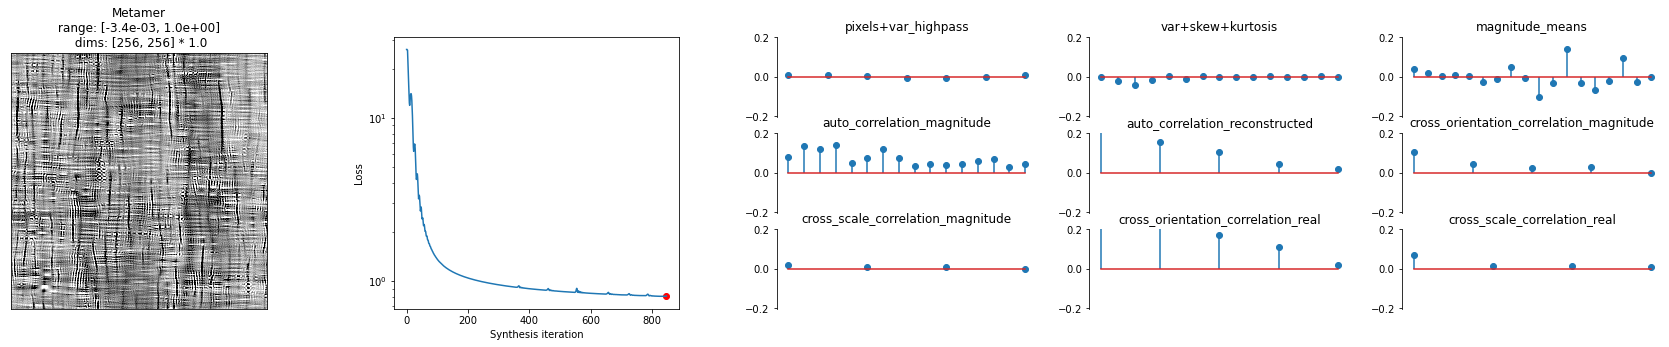

In [31]:
po.synth.metamer.plot_synthesis_status(met, width_ratios={'model_response_error': 3.1});

# 5. Notable differences between Matlab and Python Implementations:

1. Optimization.  The matlab implementation of texture synthesis is designed specifically for the texture model.  Gradient descent is performed on subsets of the texture statistics in a particular sequence (coarse-to-fine, etc.).  Because of the way it is designed, it is actually completely deterministic.  The python implementation relies on the auto-differentiation and optimization tools available in pytorch.  We only define the forward model and then allow pytorch to handle the optimization.

    Why does this matter? We have qualitatively reproduced the results but cannot guarantee exact reproducibility. This is also true in general for the plenoptic package: [https://plenoptic.readthedocs.io/en/latest/reproducibility.html](https://plenoptic.readthedocs.io/en/latest/reproducibility.html) This means that we cannot guarantee that the synthesis will match exactly across the two implementations.
 
 
2. In the Matlab implementation of Portilla Simoncelli statistics and when the python is set with use_true_correlations=False, the auto-correlation, cross-scale and cross-orientation statistics are based on co-variance matrices.  For the python optimization, this makes it more difficult for the optimization to converge.  We have adjusted the defult behavior of the python implementation to use cross-correlation matrices instead of covariance matrices for these auto-correlation, cross-scale, and cross-orientation statistics.

    In the case where use_true_correlation=False, the matlab and python statistics calculations are identical up to floating point error.  We test for this directly in tests/test_models.py in the function: test_ps_torch_v_matlab

  0%|          | 0/1000 [00:00<?, ?it/s]

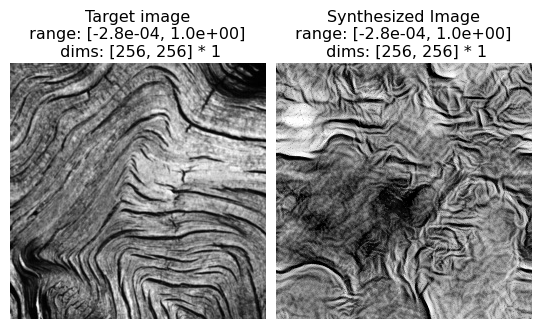

In [20]:
# Example of synthesis where use_true_correlations=True
metamer = run_synthesis(DATA_PATH + 'fig6a.jpg')
po.imshow([metamer.target_signal, metamer.synthesized_signal], title=['Target image', 'Synthesized Image'], vrange='auto1');

  0%|          | 0/1000 [00:00<?, ?it/s]

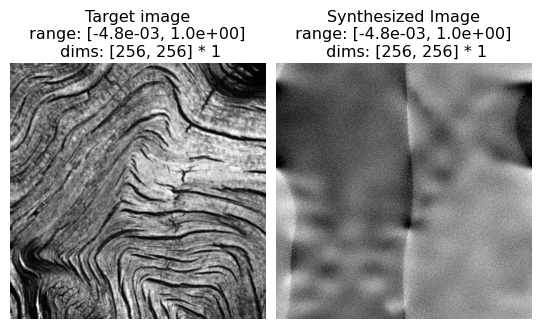

In [21]:
# Example of synthesis where use_true_correlations=False
metamer = run_synthesis(DATA_PATH + 'fig6a.jpg',use_true_correlations=False)
po.imshow([metamer.target_signal, metamer.synthesized_signal], title=['Target image', 'Synthesized Image'], vrange='auto1');